In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021).

$\psi(P_0) = \mathbb{E}[Y|X=x]$  is our target estimand - it is the conditional outcome mean.

i.e. $$\psi(P_0) = \int y \frac{f_{y,x}(y,x)}{f_x(x)} dy $$


If we assume the distribution from which the densities $f$ derive has been perturbed by a point mass at $(\tilde x, \tilde y)$ then:

i.e. $$\psi(P_t) = \int y \frac{f_{y,x,t}(y,x)}{f_{x,t}(x)} dy $$

where $f_{y,x,t}(y,x)$ and $f_{x,t}(x)$ are the joint and marginal densities of $(Y,X)$ and $(X)$ respectively, under the 'parametric submodel' $$P_t = t\delta_x(\tilde x) + (1-t)P_o$$ and where $\delta_x(\tilde x)$ denotes the Dirac delta function s.t. it gives the density of a point mass at $\tilde x$, is zero everywhere else, and integrates to 1.

For our densities we therefore have that:

$$f_{y,x,t}(x,y) =  t \delta_{x,y}(\tilde x, \tilde y) +  (1-t)f_{x,y}(x,y)$$

and

$$f_{x,t}(x) =  t \delta_{x}(\tilde x) +  (1-t)f_{x}(x)$$.

For some single observation $\tilde o$, the influence function can be written as:

$$\phi(\tilde o, P) = \left. \frac{d\psi(P_t)}{dt} \right \vert_{t=0} = \int y \left . \frac{d}{dt} \right \vert_{t=0}\frac{f_{x,y,t}(x,y)}{f_{x,t}(x)}dy$$

Following the quotient rule:
$$\phi(\tilde o, P) = \int\left .\frac{y}{f(x)} \frac{df_{x,y,t}(x,y)}{dt} \right \vert_{t=0} dy  - \int\left .\frac{ydf_{x,t}(x)}{dt} \frac{f_{x,y,t}(x,y)}{f(x)^2} \right \vert_{t=0} dy$$

Now $$\left. \frac{df_{y,x,t}(x,y)}{dt}\right \vert_{t=0} =  \delta_{x,y}(\tilde x, \tilde y) -f_{x,y}(x,y)$$

and 
$$\left. \frac{df_{x,t}(x)}{dt} \right \vert_{t=0} =  \delta_{x}(\tilde x) -f_{x}(x)$$

Therefore, with some manipulation and remembering that $\delta_{x,y}(\tilde x, \tilde y) = \delta_{x}(\tilde x) \delta_{y}(\tilde y) $

$$ \phi(\tilde o, P) = \frac{\delta_{x}(\tilde x) }{f(\tilde x)} \left( \tilde y - \mathbb{E}[Y|X=\tilde x]\right )$$

This is fine if $X$ is discrete, since in this case $\delta_{x}(\tilde x)$ is the indicator function and $\delta_x(x)=1$.

### 1. Generate some data $p_n(X,Y)$, calculate some example ground truths.

For the example, we will use a 4 dimensional Bernoulli distribution, and include an intercept and interaction term

Ground Truth E(Y|X=x):  3.3


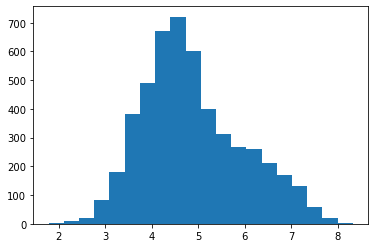

In [12]:
N = 5000

def data_gen(N, beta):
    X0 = np.array([1.0]).repeat(N).reshape(-1, 1)
    X1 = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X2 = np.random.binomial(1, 0.8, N).reshape(-1, 1)
    X3 = np.random.binomial(1, 0.3, N).reshape(-1, 1)
    X4 = np.random.binomial(1, 0.6, N).reshape(-1, 1)
    X = np.concatenate([X0, X1, X2, X3, X4, X2*X3], 1)
    u = 0.5 * np.random.randn(N)
    y = np.dot(X, beta) + u
    
    return X[:,1:-1], X, y, u  # first output is the variables without the constant and interaction

beta = np.array([3.3, 0.6, 0.5, 0.9, 0.6, 1.0])  # set beta/coefficients to some values
X, X_all, y, u = data_gen(N=N, beta=beta)  # generate the data

# set our query value of X=x:
cond_X_GT = np.array([1., 0., 0., 0., 0., 0.0])  # note the last var has to be X2*X3

# simulatedata gen process (without noise) for purposes of finding E(Y|X=x)
Psi_GT = np.dot(cond_X_GT, beta)  
print('Ground Truth E(Y|X=x): ', Psi_GT)
plt.hist(y, bins=20)
plt.show()

### 2. Split into two (_ds1 and _ds2)

In [13]:
X_ds1 = X[: len(X)//2]
X_ds2 = X[len(X)//2 :]
y_ds1 = y[: len(y)//2]
y_ds2 = y[len(y)//2 :]

### 3. Estimate $\hat\psi_{ds_1}$ Using a Random Forest Regressor


In [14]:
cond_X_est = cond_X_GT[1:-1]  # excludes offset and interaction. 

reg = RandomForestRegressor().fit(X_ds1, y_ds1)
psi_ds1 = reg.predict((cond_X_est).reshape(1, -1))
print('Ground Truth E(Y|X=x): ', Psi_GT)
print('Psi estimate using RF trained on ds_1: ', psi_ds1[0])
print('Relative error for ds_1 estimate: ', np.round((np.abs(psi_ds1-Psi_GT) / Psi_GT * 100)[0],4), 'percent')

Ground Truth E(Y|X=x):  3.3
Psi estimate using RF trained on ds_1:  3.293332854714451
Relative error for ds_1 estimate:  0.202 percent


### 4. Estimate f(x) using ds_1

Note that X is 4 dimensional and each dimension is Bernoulli distributed (i.e. each draw yields 0 or 1). The probability of each event in X needs to be estimated from the data.

For this we are going to use ds_1 to estimate the PMF, and then, when we need to use it, we can plug the values from ds_2 into this estimated PMF.



In [15]:
# define a function that returns p(X=x) given the PMF p(X) and space of possible X
def pmf(x, cats, p_cats):
    ''' takes in set of possible outcomes 'cats' and corresponding probabilitys p_cats
    output is probability of specified event 'x' '''
    ind = np.where((cats==x).all(axis=1))[0][0]
    return p_cats[ind]

# return the set of possible outcomes, and their counts for X_ds1
cats_ds1, counts_ds1 = np.unique(X_ds1, axis=0,return_counts=True)
p_cats_ds1 = counts_ds1 / len(X_ds1)  # this returns the normalized probabilities for each possible outcome



### 5. Now to compute the IFs for ds_1
$$ \phi(\tilde x, P) = \frac{\delta_{x}(\tilde x) }{f(\tilde x)} \left( \tilde y - \mathbb{E}[Y|X=\tilde x]\right )$$

In [16]:
all_phi_ds2s = []
for i in range(len(X_ds2)):
    y_tilde = y_ds2[i]
    x_tilde = X_ds2[i]
    EY_tildeX = reg.predict(x_tilde.reshape(1, -1))
    y_Ey = y_tilde - EY_tildeX
    delta_over_fx = 1 / pmf(x_tilde, cats_ds1, p_cats_ds1)
    all_phi_ds2s.append(delta_over_fx * y_Ey)
    
all_phi_ds2s = np.asarray(all_phi_ds2s)    

### 6. Repeat steps  3-5 with the other datasplit

In [17]:
# refit the RF on the other sample
reg = RandomForestRegressor().fit(X_ds2, y_ds2)
psi_ds2 = reg.predict((cond_X_est).reshape(1, -1))
print('Ground Truth E(Y|X=x): ', Psi_GT)
print('Psi estimate using RF trained on ds_2: ', psi_ds2[0])
print('Relative error for ds_2 estimate: ', np.round((np.abs(psi_ds2-Psi_GT) / Psi_GT * 100)[0],4), 'percent')

# this returns the set of possible outcomes, and their counts for the 2nd sample
cats_ds2, counts_ds2 = np.unique(X_ds2, axis=0,return_counts=True)
p_cats_ds2 = counts_ds2 / len(X_ds2)  # this returns the normalized probabilities for each possible outcome

all_phi_ds1s = []
for i in range(len(X_ds1)):
    y_tilde = y_ds1[i]
    x_tilde = X_ds1[i]
    EY_tildeX = reg.predict(x_tilde.reshape(1, -1))
    y_Ey = y_tilde - EY_tildeX
    delta_over_fx = 1 / pmf(x_tilde, cats_ds2, p_cats_ds2)
    all_phi_ds1s.append(delta_over_fx * y_Ey)
    
all_phi_ds1s = np.asarray(all_phi_ds1s)    

Ground Truth E(Y|X=x):  3.3
Psi estimate using RF trained on ds_2:  3.240071126398865
Relative error for ds_2 estimate:  1.816 percent


### 7. Average the IF estimates from both datasplits

In [18]:
phi_est = (all_phi_ds1s.mean() + all_phi_ds2s.mean())/2

### 8. Average the Psi estimates from both datasplits

In [19]:
psi_est =  (psi_ds1 + psi_ds2) / 2

print('Ground Truth E(Y|X=x): ', Psi_GT)
print('Average Psi estimate across both dataplits: ', psi_est[0])
print('Relative error average estimate: ', np.round((np.abs(psi_est-Psi_GT) / Psi_GT * 100)[0],4), 'percent')


Ground Truth E(Y|X=x):  3.3
Average Psi estimate across both dataplits:  3.2667019905566583
Relative error average estimate:  1.009 percent


### 9. Update Estimate

This is computed as:

$$ \psi(P) \approx \psi(P_n) + \frac{1}{N}\sum_{i=0}^N\phi(\tilde o_i, P_n)$$

which follows the Von Mises process for approximating a functional at an unknown distribution as a sum of terms involving the functional at the current distribution plus some derivatives (in our case, pathwise derivative) and higher order terms. 

In [20]:
psi_est_updated = psi_est + phi_est

print('Ground Truth E(Y|X=x): ', Psi_GT)
print('Average Psi estimate UPDATED: ', psi_est_updated[0])
print('Relative error UPDATED estimate: ', np.round((np.abs(psi_est_updated-Psi_GT) / Psi_GT * 100)[0],4), 'percent')
print('Reduction in bias: ', np.round(np.round((np.abs(psi_est-Psi_GT) / Psi_GT * 100)[0],4) - np.round((np.abs(psi_est_updated-Psi_GT) / Psi_GT * 100)[0],4),4), 'percent')

Ground Truth E(Y|X=x):  3.3
Average Psi estimate UPDATED:  3.1946108832401823
Relative error UPDATED estimate:  3.1936 percent
Reduction in bias:  -2.1846 percent
